In [ ]:
from PIL import Image
import torchvision.transforms.functional as TF
from torchvision import transforms
import torch as t
import torch.nn.functional as F
from fastai.vision.data import get_grid
import matplotlib.pyplot as plt
import glob
from PIL.JpegImagePlugin import JpegImageFile
import numpy as np
from einops import rearrange
import os

In [ ]:
from RSF.RSF import *
from RSF.utils import *

In [ ]:
#hide
os.chdir('../')
os.getcwd()

'/home/me/github/RSF'

## Preparation 

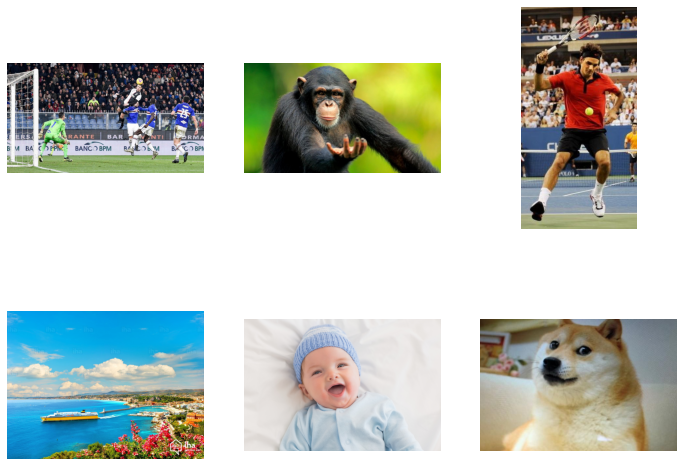

In [ ]:
images = [Image.open(path) for path in glob.glob('./data/samples/**.jpg', recursive=True)]
plot_images(images)

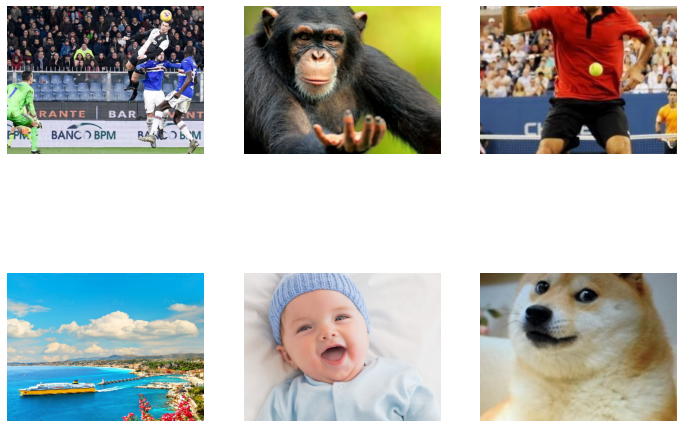

In [ ]:
c, h, w = 3, 300, 400
image_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize(w),
    transforms.CenterCrop((h, w))
])

XC = t.stack([image_transform(im) for im in images]) # C for Colour
plot_images(XC)

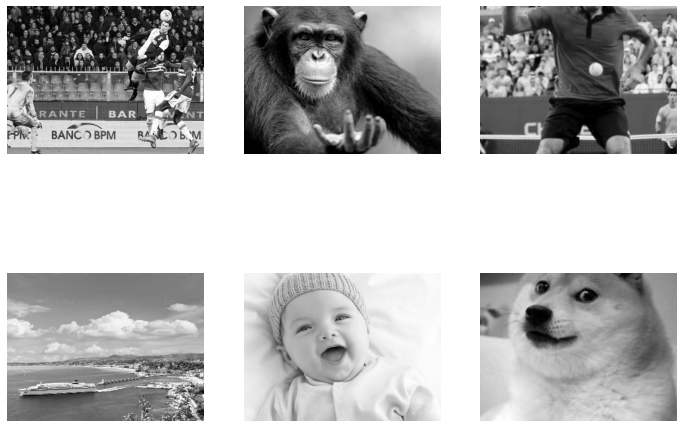

In [ ]:
c, h, w = 1, 300, 400
image_transform = transforms.Compose([
    transforms.Grayscale(),
    transforms.ToTensor(),
    transforms.Resize(w),
    transforms.CenterCrop((h, w))
])

XG = t.stack([image_transform(im) for im in images]) # G for Gray
plot_images(XG)

## Famous Filters

### Sobel Filter

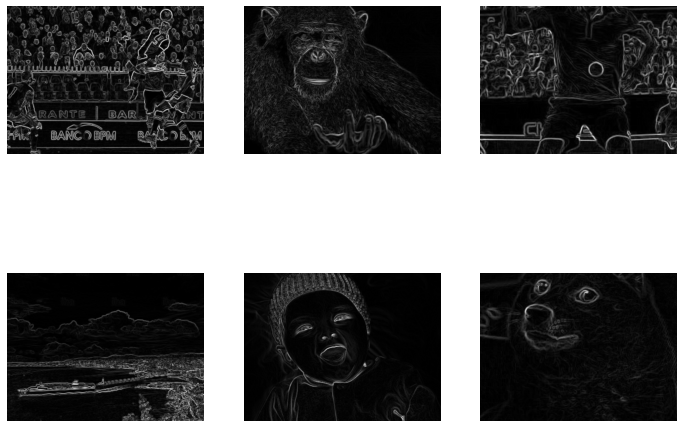

In [ ]:
Gx_w = [
    [-1., 0., +1.],
    [-2., 0., +2.],
    [-1., 0., +1.]]
Gy_w = [
    [+1., +2., +1.],
    [0.0, 0.0, 0.0],
    [-1., -2., -1.]]

out_x = conv2d(XG, Gx_w)
out_y = conv2d(XG, Gy_w)

output = t.sqrt(t.pow(out_x,2)+t.pow(out_y,2))
plot_images(output)

In [ ]:
out_x = conv2d(XC, Gx_w, padding=1)
out_y = conv2d(XC, Gy_w, padding=1)

out = t.sqrt(t.pow(out_x,2)+t.pow(out_y,2))
plot_images(out/out.view(4, 3, -1).max(2)[0].reshape(4,3,1,1))

RuntimeError: The size of tensor a (6) must match the size of tensor b (4) at non-singleton dimension 0

### Box blur

In [ ]:
n = 15
W = [[1/n**2]*n]*n
out = conv2d(XG, W)

plot_images(out)

In [ ]:
out = conv2d(XC, W)
plot_images(out)

### Sharpen 

In [ ]:
W = [
    [0.0, -1., 0.0],
    [-1., 5.0, -1.],
    [0.0, -1., 0.0],
]

out = conv2d(XG, W)
plot_images(out)

In [ ]:
out = conv2d(XC, W)
plot_images(out)

### Edge Detection

In [ ]:
W = [
    [-1., -1., -1.],
    [-1., 8.0, -1.],
    [-1., -1., -1.],
]

out = conv2d(XG, W)
plot_images(out)

In [ ]:
out = conv2d(XG, W)
plot_images(out)

## Separability Map

### Integral Map 

In [ ]:
def integral_image(X): # For batch
    for i in range(1, X.ndim):
        X = X.cumsum(i)
    return X

IG = integral_image(XG)
plot_images(IG)

### Rectangular Seperability Filter 

The rectangular seperability filter is made from 3 smaller rectangles.

In [ ]:
P2.shape

In [ ]:
 TF.resize(out, XG.shape[-2:]).shape, out.shape

In [ ]:
def plot_filter(W, title=''):
    plt.imshow(W)
    plt.title(title)
    plt.show()

out = t.zeros(XG.shape)
for i in range(1, np.prod(out.shape[-2:])):
    t1, t2, t3 = i, i, i

    R1 = np.asarray([[1/t3/t1/2]*t3]*t1*2)
    R2 = np.asarray([[1/t2/t3]*t3]*t2)
    N1 = R1.size
    N2 = R2.size
    N = N1 + N2

    # plot_filter(R1)
    # plot_filter(R2)
    # plot_filter()


    P1_w = np.vstack((R2*0, R1, R2*0))
    P1 = conv2d(XG, P1_w, padding=(t1+t2, t3//2))
    # plot_images(P1)

    P2_w = np.vstack((R2, R1*0, R2))
    P2 = conv2d(XG, P2_w, padding=(t1+t2, t3//2))
    # plot_images(P2)

    Pbar_w=  np.vstack((R2, R1, R2))
    Pbar = conv2d(XG, Pbar_w, padding=(t1+t2, t3//2))
    Pbar2 = conv2d(t.pow(XG, 2), Pbar_w, padding=(t1+t2, t3//2))
    # plot_images(Pbar)

    Sb = (N1/N) * t.pow((P1 - Pbar), 2) + (N2/N) * t.pow(P2 - Pbar, 2)
    # plot_images(Sb)

    St = Pbar2 - t.pow(Pbar, 2)
    # plot_images(St)

    out = t.maximum(out, TF.resize(Sb / St, XG.shape[-2:]))
    
plot_images(out)

In [ ]:
plot_images(out)

In [ ]:
Sb = (N1/N) * t.pow((P1 - Pbar), 2) + (N2/N) * t.pow(P2 - Pbar, 2)
plot_images(Sb)

St = Pbar2 - t.pow(Pbar, 2)
plot_images(St)

out = Sb / St
plot_images(out)

In [ ]:
out

In [ ]:
def integral_image(X): # For batch
    for i in range(1, X.ndim):
        X = X.cumsum(i)
    return X

IC = integral_image(XC) 
IC /= IC.numpy().max()
plot_images(IC)